# Blurr Sequence Classification with categorical and numerical features using BERT.

This notebook is a replication of the http://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/ but use blurr to showcase how to combine bert with categorical & numerical featuers with text in BERT.

Additional Resources
- https://github.com/georgian-io/Multimodal-Toolkit
- https://medium.com/georgian-impact-blog/how-to-incorporate-tabular-data-with-huggingface-transformers-b70ac45fcfb4

Next Step
- Following this notebook https://colab.research.google.com/drive/1YRHK4HO8RktGzlYmGjBo056kzVD4_j9o#scrollTo=m7rr8z8x3TiE 3.3 Training Paremeters 

TODO 
- Callback, why partial on the optimizer
- Does freezing the final layer followed by unfreeze works in transformer context??. I recall nobody adopted gradual unfreezing not adopted in practice. 

**Checklist** (1. Make it work using high/mid/low 2. Baseline)
- [ ] BERT on Review Text Only (Sample Data)
  - [ ] High Level (Accuracy - 0.83)
  - [x] Mid Level (Accuracy - 0.914)
  - [ ] Low Level
- [ ] BERT on All features (Sample Data) - Unimodal approach (taking the categorical and numerical features as they are and just tokenizing them and just concatenating them to the text columns as extra text sentences is a strong baseline as referenced in the [multimodal-toolkit](https://github.com/georgian-io/Multimodal-Toolkit)
  - [ ] High Level
  - [ ] Mid Level
  - [ ] Low Level

## Outline

- Installation
- Womens Clothing Review Dataset
  - Download the womens clothing data
  - Load the csv
- BERT on Review Text Only
  - Using MidLevel API
- Create the blearner for Sequence Classification
- Fit OneCycle
- Evaluate 

In [1]:
%%capture
%pip install nbdev -q --upgrade
%pip install fastai -q --upgrade
%pip install -q huggingface-hub>0.0.10
%pip install ohmeow-blurr -q --upgrade

In [2]:
%pip install nbverbose -Uq

In [3]:
from datasets import load_dataset, concatenate_datasets

In [4]:
#export
import os

from datasets import load_dataset, concatenate_datasets
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from blurr.data.language_modeling import BertMLMStrategy, CausalLMStrategy
from blurr.modeling.language_modeling import *

from blurr.modeling.token_classification import *
from blurr.modeling.question_answering import *
from blurr.modeling.seq2seq.summarization import *
from blurr.modeling.seq2seq.translation import *

logging.set_verbosity_error()

In [5]:
import importlib
from typing import List, Union
def print_versions(
    # A string of space delimited package names or a list of package names
    packages:Union[str, List[str]]
):
    """ Prints the name and version of one or more packages in your environment"""
    packages = packages.split(' ') if isinstance(packages, str) else packages

    for item in packages:
        item = item.strip()
        # Provides the implementation of import statement and allows to import the defined packages to retrieve their versions.
        print(f'{item}: {importlib.import_module(item).__version__}')

In [6]:
#hide_input
import pdb

from fastcore.test import *
from nbverbose.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions('torch fastai transformers')

Here's what we're running with ...

torch: 1.9.0+cu102
fastai: 2.5.2
transformers: 4.10.3


In [7]:
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #0: Tesla K80


## Clothing Review Dataset

Based on the womens clothing reviews, we are trying to predict the sentiment behind the review (Recommended IND is the label where 1 indicates recommended & 0 indicates not recommended).

### Download the csv file

This dataset was scraped from an (un-specified) e-commerce website by Nick Brooks and made available on Kaggle [here](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).

In [8]:
import gdown

In [9]:
# Download the dataset from the drive.
gdown.download('https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H', 
                'Womens Clothing E-Commerce Reviews.csv', 
                quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZYdt0zN4LjWqP3cQDblNhXjeohcryY5H
To: /content/Womens Clothing E-Commerce Reviews.csv
8.48MB [00:00, 44.4MB/s]


'Womens Clothing E-Commerce Reviews.csv'

In [10]:
test_eq(Path('/content/Womens Clothing E-Commerce Reviews.csv').exists(), True)

### Load the csv 

In [11]:
FILENAME = '/content/Womens Clothing E-Commerce Reviews.csv'
df = pd.read_csv(FILENAME, index_col=0)

In [12]:
len(df)

23486

In [13]:
list(df.columns)

['Clothing ID',
 'Age',
 'Title',
 'Review Text',
 'Rating',
 'Recommended IND',
 'Positive Feedback Count',
 'Division Name',
 'Department Name',
 'Class Name']

In [14]:
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [15]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [16]:
# Determine the columns containing null/missing values
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [17]:
# Lets drop the rows containing null values.
df.dropna(inplace=True)

In [18]:
len(df)

19662

It seems we are dropping too many samples due to missing values. Instead of dropping the missing values rows, can we fill the missing values. 

Let's reload the df from the csv file.

In [19]:
df = pd.read_csv(FILENAME, index_col=0)

In [20]:
test_eq(len(df), 23486)

In [21]:
df.head(1).values

array([[767, 33, nan,
        'Absolutely wonderful - silky and sexy and comfortable', 4, 1, 0,
        'Initmates', 'Intimate', 'Intimates']], dtype=object)

In [22]:
df.Rating.value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

In [23]:
df['Division Name'].value_counts()

General           13850
General Petite     8120
Initmates          1502
Name: Division Name, dtype: int64

In [24]:
df['Department Name'].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: Department Name, dtype: int64

In [25]:
df['Class Name'].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: Class Name, dtype: int64

In [26]:
df.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

Let's fill the missing valeues(NaN) with empty.

In [27]:
df = df.fillna('')

The approach described in the [article](http://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/#31-all-features-to-text) to handle non-text features is to convert them into text and concatenate them with the review text. Instead of that we will instead try with the approach of "mark_fields"[1] that is done in fastai. Basically it will prepend the field text along with a token indicating which field this is from. 

Ex: fld 1 this is a bert example fld 2 this is the second sentence 

__Approach 1__
But BERT itself adds some special tokens, so we can instead try [CLS] field 1 text [SEP] field 2 text [SEP] (eg: Dresses [SEP] General [SEP] 34 [SEP] 5...  

[1] https://docs.fast.ai/text.data.html#TextBlock.from_df

__Approach 2__
Create a special tokens for each of the feature column and prepend it based on the idea from [ME ULMFiT](https://www.novetta.com/2019/03/introducing_me_ulmfit/). [CLS] [FLD1] field 1 text [FLD2] field 2 text [INP] text input [SEP] 



## BERT on Review Text Only (Sample Data)

In [30]:
from sklearn.model_selection import train_test_split
SEED=42
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED)
len(train_val_df), len(test_df)

(21137, 2349)

#### Sample Data

In [31]:
# Use sample data
train_val_df = train_val_df.sample(frac=0.1); len(train_val_df)

2114

### Using the Midlevel API 

In [28]:
from transformers import AutoModelForSequenceClassification
model_cls = AutoModelForSequenceClassification

pretrained_model_name =  "bert-base-uncased" #"distilroberta-base" # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
# Set the number of labels 
hf_config.num_labels = df['Recommended IND'].nunique()

#### DataBlock and DataLoaders

In [32]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
db = DataBlock(blocks=blocks, get_x=ColReader('Review Text'), get_y=ColReader('Recommended IND'), 
               splitter=RandomSplitter(valid_pct=0.1, seed=SEED))

In [33]:
train_val_df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [36]:
#TfmdLists - Uncomment the summary to see the whole process
#db.summary(train_val_df[:100])

In [37]:
dls = db.dataloaders(train_val_df, bs=32)

In [38]:
b = dls.one_batch(); len(b), len(b[0]['input_ids']), b[0]['input_ids'].shape, len(b[1])

(2, 32, torch.Size([32, 152]), 32)

In [39]:
explode_types(b)

{tuple: [dict, fastai.torch_core.TensorCategory]}

In [40]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"i just got this in the green and i'd say the color is deeper / darker than shown. more of a turquoise - green, or muted teal color. it's the densest, thickest cashmere ( it's 100 % cashmere ) i've felt in a while and it's so soft. but, it just doesn't look good on me. i'm 5'3 "" and about 105 lbs, and usually wear xspetite. i got this in the xs regular hoping it would be long enough for leggings. and i don't think it is in the back. plus it's just too bell shaped and i'm slightly pear - shaped al",1
1,"this dress is indeed so lovely in person. i am so glad i ordered 2 sizes ( 0p and 2p ) based on the straighter - looking cut. i am 115 lbs, 5'1. 5 "", adn 30dd bra size. verdict, the 2p fit better. why, the cehst area is a little snug and hte buttons kept trying to open ( and did # i would have ahd to leave it pen and wear a tank under this dress... not an option with such a unique piece. other things : color : wow, very nice in person, i was afraid that the colr would wash me out, but no, i have",1


#### Training

In [41]:
model = HF_BaseModelWrapper(hf_model)

In [42]:
doc(Learner)

In [ ]:
#TODO - Callback, why partial on the optimizer 

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
                metrics=accuracy, cbs=[HF_BaseModelCallback], splitter=hf_splitter).to_fp16()
learn.freeze()

In [ ]:
# Uncomment and see the architecture and learner details.
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(minimum=9.12010818865383e-08, steep=6.309573450380412e-07, valley=0.00363078061491251, slide=0.0012022644514217973)

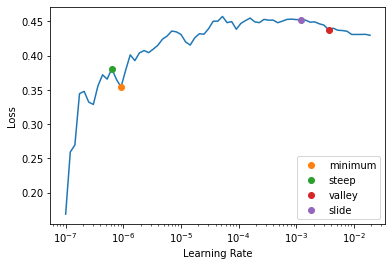

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-6)

epoch,train_loss,valid_loss,accuracy,time
0,0.437359,0.445859,0.838863,01:34


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.00015848931798245758)

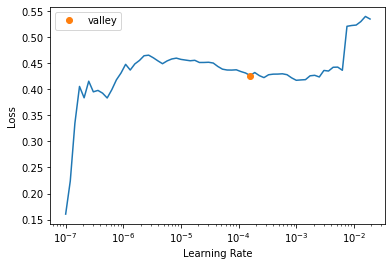

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.371937,0.309550,0.881517,01:54


In [ ]:
learn.fit_one_cycle(3, lr_max = slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.279243,0.232797,0.900474,01:54
1,0.199191,0.215759,0.914692,01:54
2,0.140689,0.220340,0.914692,01:54


We are getting 91% accuracy with just 10% of the data.

In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,target,prediction
0,"truly the only word that comes to mind when i think of this dress is dazzling! the pictures online just barely do it justice... if you have an retailer nearby, check to see if its available in store and go check it out in person. it does not disappoint! every year around this time, our beloved retailer seems to come out with this style of dress. in the years past they have all been different and beautiful, but i think they have truly outdone themselves this year. this dress is a deep emerald green...",1,1
1,"this sweater sold out fast at my local retailer store. you know that stuffed animal that you owned when you were a kid, and you would never let it go because it was so soft and snuggly? yeah, it is like that for me. it's a bit pilly but that's what sweaters do. size petite s fit me perfectly ( i am 5ft2in, 34b, 26 waist, 36 hips ), hem falls 4 inches above my knees, sleeves fall right at my wrist, and it gives room for wearing a sweater or turtleneck under it. hood lays flat, horse print is so cute.",1,1


### High Level API

In [ ]:
doc(BlearnerForSequenceClassification.from_dataframe)

In [49]:
# Using Blearner
learn = BlearnerForSequenceClassification.from_dataframe(train_val_df, 
                                                'bert-base-uncased',
                                                 text_attr='Review Text',
                                                 label_attr='Recommended IND',
                                                 n_labels=2,
                                                 dblock_splitter=RandomSplitter(valid_pct=0.1, seed=SEED))
learn = learn.to_fp16()

In [50]:
learn.dls.show_batch(dataloaders=learn.dls, trunc_at=500, max_n=5)

,text,target
0,"i just got this in the green and i'd say the color is deeper / darker than shown. more of a turquoise - green, or muted teal color. it's the densest, thickest cashmere ( it's 100 % cashmere ) i've felt in a while and it's so soft. but, it just doesn't look good on me. i'm 5'3 "" and about 105 lbs, and usually wear xspetite. i got this in the xs regular hoping it would be long enough for leggings. and i don't think it is in the back. plus it's just too bell shaped and i'm slightly pear - shaped al",1
1,"this dress is indeed so lovely in person. i am so glad i ordered 2 sizes ( 0p and 2p ) based on the straighter - looking cut. i am 115 lbs, 5'1. 5 "", adn 30dd bra size. verdict, the 2p fit better. why, the cehst area is a little snug and hte buttons kept trying to open ( and did # i would have ahd to leave it pen and wear a tank under this dress... not an option with such a unique piece. other things : color : wow, very nice in person, i was afraid that the colr would wash me out, but no, i have",1
2,"for me, this top ran true to size. i'm so glad i ordered it in my normal size, because the spandex would have made the top way too clingy for me. i am normally a 8 / medium on top and 12 bottom. i ordered this in a medium, and don't find it large at all. if you are going for a fitted look, sizing down may be best, but i didn't want it tight. on me, it's a little looser than what is shown on the model, but it still fits very nice, and not sloppy. i am not a fan of baggy tops. i have no issues wit",1
3,"let me talk about the fit. i am a size 6 petite. i weigh 120 and am 5'tall. i am curvy and have short legs. what little height i have is in my torso. that being said, i ordered the 6p and the 6. no doubt about it! the 6p fits like a 4p. the 6p was tight in the hips and thighs. the size 6 regular was a perfect fit. if you want the pant to have s cropped look like in the picture then order up a size and stay in petite. so i would have ordered a 8p i'd i wanted the cropped look like in the pic. bu",1
4,"the label says 100 % linen, but it's so silky and drapey that it feels like silk and linen. it's not a scratchy linen at all. it's a very very fine knit, but the top is not sheer. i don't think you need a cami under it. i bought the xl and the fit is just as shown. it has a slight drape, but it's not really baggy at all. i bought the grey and it looks lighter on - line that it really is. it's a bit darker and has a silver essence also. i liked this so much, i just bought another one in mauve.",1


In [51]:
#learn.summary()
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, MixedPrecision, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [HF_BaseModelCallback, MixedPrecision]
         - after_pred     : [HF_BaseModelCallback, MixedPrecision]
         - after_loss     : [HF_BaseModelCallback, MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train bat

SuggestedLRs(minimum=0.006918309628963471, steep=0.001737800776027143, valley=0.0008317637839354575, slide=0.005248074419796467)

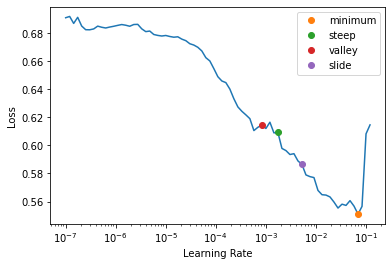

In [45]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [46]:
learn.summary()

HF_BaseModelWrapper (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 152 x 768      
Embedding                                 23440896   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
           

In [47]:
learn.fine_tune(3, base_lr=5e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.517784,0.455757,0.908136,0.834123,01:36


epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.323233,0.215455,0.948571,0.914692,01:57
1,0.264858,0.257258,0.932945,0.890995,01:57
2,0.172162,0.289080,0.920455,0.867299,01:57


In [53]:
learn.fit_one_cycle(1, lr_max=5e-3)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.454338,0.393269,0.906736,0.829384,01:36


Before unfreeze (learning rate finder)

SuggestedLRs(minimum=0.00036307806149125097, steep=5.754399353463668e-06, valley=0.0005754399462603033, slide=0.0014454397605732083)

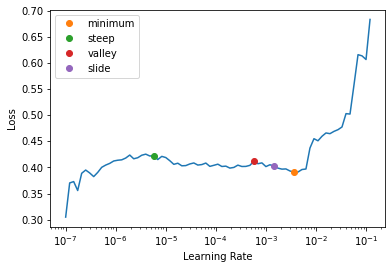

In [54]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [55]:
learn.unfreeze()

After unfreezing (learning rate finder)

SuggestedLRs(minimum=1.0964782268274575e-05, steep=2.75422871709452e-06, valley=2.511886486900039e-05, slide=0.005248074419796467)

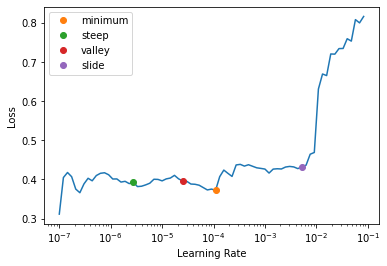

In [56]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [57]:
learn.fit_one_cycle(2, lr_max=slice(2.5e-5))

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,0.388074,0.356095,0.906736,0.829384,01:57
1,0.369915,0.336681,0.906736,0.829384,01:57


### Low Level API

1. GPU & Transformers Setup
2. Create Datasets
3. Create DataLoaders
4. Trainer API or Pytorch training loop.

GPU & Transformers Setup

In [61]:
import torch

# if GPU is available inform pytorch to use GPU as the device else use CPU
if torch.cuda.is_available():
  device = torch.device('cuda')

  print(f'There are {torch.cuda.device_count()} GPU(s) available')
  print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available
We will use the GPU: Tesla K80


Load the tokenizer

In [62]:
from transformers import BertTokenizerFast
# Load tokenizer
print('Load BERT tokenizer')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Load BERT tokenizer


Load the BERT Classification model

In [63]:
from transformers import BertForSequenceClassification

In [64]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)
#Inform pytorch to run the model on GPU
desc = model.cuda()

Training Parameters

In [65]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 4

Maximum Sequence Length is another keyparameter which will a) truncate or b) pad all of samples to. Setting higher value of max seq len will increase memory & increase the training time. 

Let's determine this by passing over the dataset to find the longest sequence & we will choose it based on this.

In [ ]:
df

## BERT with All Features (Sample Data)

In [ ]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [ ]:
def get_x(row):
  combined = ""

  combined = f"{combined} [SEP] {row['Age']} [SEP] {row['Rating']} [SEP] {row['Positive Feedback Count']} [SEP] {row['Division Name']} [SEP] {row['Department Name']} [SEP] {row['Class Name']} [SEP] "
  if row['Title']:
    combined = f"{combined} {row['Title']} [SEP] "
  
  return f"{combined} {row['Review Text']}"

In [ ]:
def _join_texts(df, mark_fields=False, cols):
    "Join texts in row `idx` of `df`, marking each field with `FLD` if `mark_fields=True`"
    text_col = (f'{FLD} {1} ' if mark_fields else '' ) + df.iloc[:,0].astype(str)
    for i in range(1,len(df.columns)):
        text_col += (f' {FLD} {i+1} ' if mark_fields else ' ') + df.iloc[:,i].astype(str)
    return text_col.values


In [ ]:
def updated_get_x(row):
  combined = ""

  combined = f"{combined} [SEP] {row['Age']} [SEP] {row['Rating']} [SEP] {row['Positive Feedback Count']} [SEP] {row['Division Name']} [SEP] {row['Department Name']} [SEP] {row['Class Name']} [SEP] "
  if row['Title']:
    combined = f"{combined} {row['Title']} [SEP] "
  
  return f"{combined} {row['Review Text']}"

In [ ]:
from transformers import AutoModelForSequenceClassification
model_cls = AutoModelForSequenceClassification

pretrained_model_name =  "bert-base-uncased" #"distilroberta-base" # "distilbert-base-uncased" "bert-base-uncased"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)


In [ ]:
hf_tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
hf_tokenizer.add_special_tokens({'additional_special_tokens':['[CAT]', '[CONT]']})

2

In [ ]:
hf_tokenizer.special_tokens_map_extended

{'additional_special_tokens': ['[CAT]', '[CONT]'],
 'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
hf_model.resize_token_embeddings

In [ ]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
db = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('Recommended IND'), 
               splitter=RandomSplitter(valid_pct=0.1, seed=SEED),
               )
dls = db.dataloaders(train_val_df, bs=32)

In [ ]:
#db.summary(train_val_df[:100])

In [ ]:
dls[0].vocab

[0, 1]

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
                metrics=accuracy, cbs=[HF_BaseModelCallback], splitter=hf_splitter).to_fp16()
learn.freeze()

SuggestedLRs(minimum=0.33113112449646, steep=0.033113110810518265, valley=0.010964781977236271, slide=0.2089296132326126)

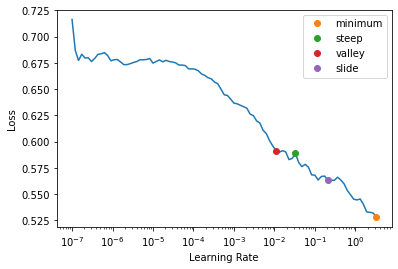

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley,])

In [ ]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.486233,0.468122,0.824645,01:52


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.013182567432522774)

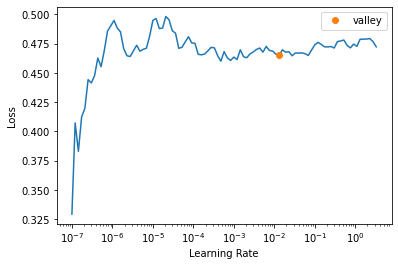

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.463354,0.439704,0.824645,02:23
1,0.406408,0.337517,0.824645,02:25
2,0.352726,0.317878,0.824645,02:23
